Aaron FARGEON  
Julien KHLAUT  
Pierre-Louis RUHLMANN

# PROJECT 3 : PERFORMANCE OF THE LASSO IN HIGH-DEMENSIONAL LINEAR REGRESSION

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from sklearn import linear_model
import seaborn as sns
from tqdm.notebook import tqdm

We consider a linear model where one observes iid observations $$y_i = x_i^T \beta^* + \varepsilon_i$$ where $x_i$ has iid $\mathcal{N}(0,1)$ entries and $\varepsilon_i \sim \mathcal{N}(0,\sigma^2)$. The goal is to study the performance of the Lasso

\begin{equation}
    \tag{L}
    \hat{\beta} = \underset{b \in \mathbb{R}^p}{\text{argmin}} \frac{1}{n} \sum\limits_{i=1}^n \frac{(y_i - x_i^T b)^2}{2} + n^{-\frac{1}{2}} \lambda \vert \vert b \vert \vert_1
\end{equation}

where $\lambda > 0$ is a tuning parameter.

We focus on the situation where if $p, n$ are high but of the same order, i.e. $\frac{n}{p} = \delta$ (or $\frac{p}{n} \rightarrow \delta$) for some constant $\delta > 0$ independent of $n,p$. We will also assume that for each $n,p$, the true $\beta^*$ is such that $\beta^*_j = \frac{\Theta_j}{\sqrt{p}}$ where $\Theta_1,...,\Theta_p$ are iid random variables of the form $\Theta_j=r_j B_j$ where $Bj$ has the Bernoulli distribution with parameter 0.128 and $r_j \in \{\pm1\}$ is a random sign independent of $B_j$ with $\mathbb{E}[r_j] = 0$. The true parameter $\beta^*$ is thus “sparse” in the sense that, approximately, only 12.8 percent of coordinates are nonzero.

#### First task  
Set $\delta = 0.64$ and $\sigma^2 = 0.2$. For each tuning parameter $\lambda$ on a grid of equispaced points in $[0,2.5]$, compute 10 different datasets with $p= 400$, $n=p \delta$, design matrix $X$ with iid entries, $\varepsilon_i \sim \mathcal{N}(0,\sigma^2)$, $\beta^* \in \mathbb{R}^p$ generated with iid components $\frac{\Theta_j}{\sqrt{p}}$ as  explained above, and for each dataset compute the  estimator $\hat{\beta}$ in $(\text{L})$ and report its performance $\vert \vert \hat{\beta} − \beta^* \vert \vert^2$ in boxplots where the $x$-axis represents $\lambda$ and the $y$-axis $\vert \vert \hat{\beta} − \beta^* \vert \vert^2$. You can for instance use seaborn’s boxplot. If your computer is sufficiently powerful, plot similar boxplots with $p = 600$ and/or $p= 800$ with always $n=p \delta$, $\delta= 0.64$.

In [5]:
def lasso(b, y, X, n, l):
    return np.mean((y - np.dot(X.T, b))**2 / 2) + (l * np.linalg.norm(b, ord = 1)) / np.sqrt(n)
    

In [8]:
delta = 0.64
sigma2 = 0.2

dataset_number = 10

grid = np.linspace(0, 2.5, 50)

p = 400
n = int(p * delta)

diff = np.zeros((len(grid), dataset_number))

for index, l in enumerate(tqdm(grid)):
    
    for k in range(dataset_number):
    
        X = np.random.normal(0, 1, size = (p,n))

        epsilon = np.random.normal(0, sigma2, size = n)

        beta_star = np.zeros(p)
        r = np.random.choice(np.array([-1,1]),size=p)
        B = np.random.binomial(1, 0.128, size=p)
        beta_star = (r * B) / np.sqrt(p)

        y = np.dot(X.T, beta_star) + epsilon

        beta_hat = opt.minimize(lasso, beta_star, args=(y, X, n, l)).x
        
        #las = linear_model.Lasso()
        #print(X.shape, y.shape)
        #las.fit(X.T, y)
        #print(las.coef_)
        
        diff[index, k] = np.linalg.norm(beta_hat - beta_star) ** 2
        #diff[index, k] = np.linalg.norm(las.coef_ - beta_star) ** 2

Text(0, 0.5, '$ || \\hat{\\beta} - \\beta^* ||$')

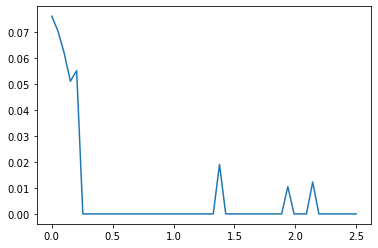

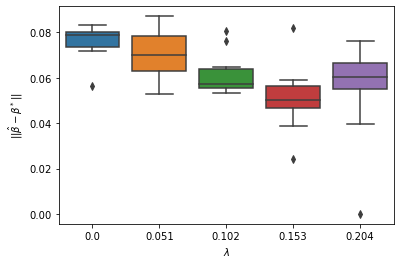

In [9]:
plt.figure()
plt.plot(grid, np.mean(diff, axis=1))
plt.figure()
grid_for_boxplot = np.repeat(grid[:5], dataset_number)
diff2 = diff[:5,:]
diff_for_boxplot = diff2.flatten()
ax = sns.boxplot(grid_for_boxplot, diff_for_boxplot)
ax.set_xticks(np.arange(0,5))
ax.set_xticklabels(np.around(grid[np.arange(0,5)], 3))
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$ || \hat{\beta} - \beta^* ||$')

#### A system of two linear equations  
Throughout, $Z \sim \mathcal{N}(0,\sigma^2)$ is a random variable independent of $\Theta$ and $\Theta$ has the same distributionas $\Theta_1,...,\Theta_p$. Your next task is to compute numerically solutions $\tau^*, b^*$ to the system of equations $$\begin{cases} \tau^2 = \sigma^2 + \frac{1}{\delta} \mathbb{E}[(\eta(\Theta + \tau Z, \frac{\tau \lambda}{b}) - \Theta)^2] \\ b = \tau (1 - \frac{1}{\delta} \mathbb{E}[\eta'(\Theta + \tau Z, \frac{\tau \lambda}{b})]) \end{cases}$$ with unknown $(\tau,b)$; here the function $\eta(u,t)$ for $u \in \mathbb{R}$ and $t \geq 0$ is given by $\eta(u,t) = \text{sign}(u) \text{max}(\vert u \vert − t,0)$. Note that the solutions $(\tau^*, b^*)$ implicitly depend on $(\lambda, \delta)$ and the distribution of $\Theta$. Changing the values of $\lambda, \delta$ modifies the values of $(\tau^*, b^*)$ although the dependence in $(\lambda, \delta)$ is implicit. To solve the above system for various values of $\lambda$, it is convenient to instead consider a parameter $\alpha >0$ such that $\alpha = \frac{\lambda}{b}$, so that the second argument of $\eta$ and $\eta'$ in the above system is reduced to $\tau \alpha$. For a given $\alpha$, the goal is to first compute a solution $\tau^*(\alpha)$ of the equation

\begin{equation}
    \tag{1}
    \tau^2 = \sigma^2 + \frac{1}{\delta} \mathbb{E}[(\eta(\Theta + \tau Z, \tau \alpha) - \Theta)^2]
\end{equation}

with unknown $\tau$. From this solution $\tau^*(\alpha)$, define  $b^*(\alpha)$ using the second equation, i.e.

\begin{equation}
    \tag{2}
    b^* (\alpha) = \tau^* (\alpha) (1 - \frac{1}{\delta} \mathbb{E}[\eta'(\Theta + \tau^* (\alpha) Z, \alpha \tau^* (\alpha))])
\end{equation}

and finally get back the correspondence between $\alpha$ and $\lambda$ by $\lambda (\alpha)$ = $\alpha b^* (\alpha)$.

#### Second task

#### Question 1  
Plot the function $u \mapsto \eta(u,t)$ for $t = 1,2,3$.

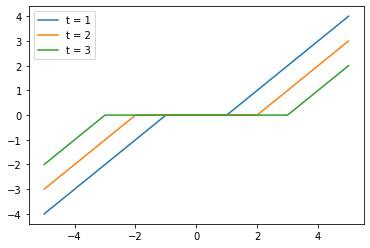

In [10]:
def eta(u,t):
    return np.sign(u) * max(abs(u) - t, 0)

plt.figure()
U = list(np.linspace(-5,5,200))
for t in [1,2,3]:
    plt.plot(U, [eta(u,t) for u in U], label = "t = " + str(t))
plt.legend()
plt.show()

#### Question 2  
What is the almost everywhere derivative of $u \mapsto \eta(u,t)$ ?

##### Answer :
It is : $$\begin{cases} \begin{array}{cl} 1 & \text{if $\vert u \vert - t > 0$} \\ 0 & \text{if $\vert u \vert - t < 0$} \end{array} \end{cases}$$

#### Question 3  
Using integration by parts, rewrite the system of nonlinear
equations to remove the expectations, using the standard normal probability density function $\phi(u) = \sqrt{2 \pi}^{−1} e{−\frac{u^2}{2}}$ and cumulative distribution function $\Phi(u) = \int_{- \infty} ^u \phi(v) \text{d}v$ (hint:
you may check your calculations by comparing your expression for equation $(1)$ to the value of $F_\alpha (\tau^2)$ given in the first few lines of the proof of lemma A.5 in https://arxiv.org/abs/1811.01212).

#### Question 4  
Propose an iterative scheme of the form $\tau_t = F_{\alpha, \delta} (\tau_{t-1})$ such that $\tau^*(\alpha)$ is a solution to $(1)$ if and only if it is a fixed point of $F_{\alpha, \delta}$.

#### Question 5  
For given $(\alpha, \lambda)$, implement in Python this numerical scheme to compute approximate $\tau^*(\alpha)$, and once $\tau^*$ is computed, im- plement the computation of $b^*(\alpha)$ and $\lambda^*(\alpha)$. You can access optimized code to compute $\phi$ and $\Phi$ in scipy.stats.norm.pdf and .cdf respectively.

In [11]:
from random import randint
import scipy.stats
phi = scipy.stats.norm.pdf
Phi = scipy.stats.norm.cdf
from math import sqrt

def solve_implement(F, alpha, delta, tho_0, sigma2, eps):
    tho_1 = tho_0
    tho_2 = sqrt(F(alpha, delta, tho_0, sigma2))
    it = 0
    while abs(tho_1 - tho_2) > eps and it < 1000:
        tho_1 = tho_2
        tho_2 = sqrt(F(alpha, delta, tho_1, sigma2))
        it += 1
    return tho_1

def F(alpha, delta, tho, sigma2):
    return sigma2 + (tho**2)*(1+alpha**2+Esp(tho, alpha, delta))/delta

def Theta():
    r = np.random.choice(np.array([-1, 1]))
    B = np.random.binomial(1, 0.128)
    return B*r

def p(i):
    if i == 0:
        return 1-0.128
    else:
        return 0.128/2

def Esp(tho, alpha, delta):
    M = 0
    for i in range(-1, 2):
        x = i / tho
        M += p(i)*((x**2 - alpha**2 - 1)*(Phi(alpha-x) - Phi(-alpha - x)) - (x + alpha)*phi(alpha - x) + (x - alpha)*phi(x + alpha)) 
    return M

def NEsp(tho, alpha, delta):
    M = 0
    for i in range(-1, 2):
        x = i / tho
        M += p(i)*(Phi(x - alpha) + Phi(-x - alpha))  
    return M

def compute_b(tho, delta, alpha):
    return tho*(1 - NEsp(tho, alpha, delta)/delta)

def compute_lambda(b, alpha):
    return b*alpha

tho_0 = sqrt(0.2 + 1/(2*0.64))
tau = solve_implement(F, 1, 0.64, tho_0, 0.2, 1e-1)
b = compute_b(tau,0.64,1)
print("tau =", tau)
print("b = ", b)

tau = 0.7385728853239243
b =  0.3236010436343045


#### Question 6  
Set $\delta = 0.64$ and $\sigma^2 = 0.2$. For a grid of $\alpha$’s equispaced in an interval of the form $[0,t]$, plot the curves (a) $(\alpha, \tau^*(\alpha))$, (b) $(\alpha, b^*(\alpha))$, (c) $(\alpha, \lambda(\alpha))$ and finally (d) $(\lambda(\alpha), \delta(\tau^∗(\alpha)^2 − \sigma^2)$. Compare curve (d) with Figure 6 in the paper *The LASSO risk for gaussian matrices* by Bayati and Montanari (2011); the curves should coincide for these values of $\delta$ and $\sigma$.

Text(0.5, 0, '$\\mathbf{\\lambda(\\alpha)}$')

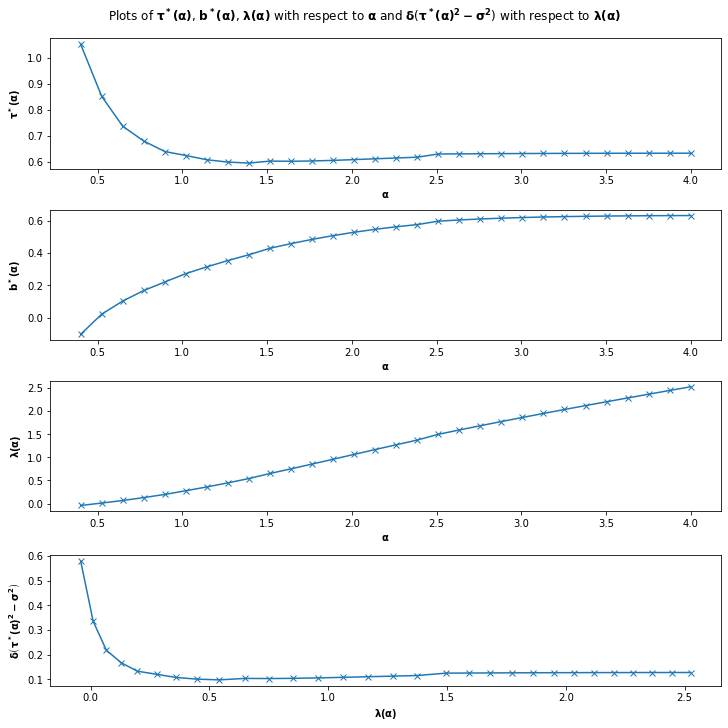

In [12]:
delta = 0.64
sigma2 = 0.2
alpha = np.linspace(0.4, 4, 30)
Tho = []
Tho_square = []
B = []
Lambda = []

fig, axs = plt.subplots(4, 1, constrained_layout=True, figsize=(10, 10))

for a in alpha:
    tho = solve_implement(F, a, delta, sqrt(sigma2 + 1/(2*delta)), sigma2, 1e-2)
    Tho.append(tho)
    Tho_square.append(delta*(tho**2-sigma2))
    b = compute_b(tho, delta, a)
    B.append(b)
    l = compute_lambda(b, a)
    Lambda.append(l)

fig.suptitle(r"Plots of $\mathbf{\tau^* (\alpha)}$, $\mathbf{b^* (\alpha)}$, $\mathbf{\lambda (\alpha)}$" \
                r" with respect to $\mathbf{\alpha}$ and $\mathbf{\delta\left( \tau^* (\alpha)^2 - \sigma^2 \right) }$"\
                r" with respect to $\mathbf{\lambda(\alpha)}$")
axs[0].plot(alpha, Tho,marker='x')
axs[0].set_ylabel(r"$\mathbf{\tau^* (\alpha)}$")
axs[0].set_xlabel(r"$\mathbf{\alpha}$")
axs[1].plot(alpha, B,marker='x')
axs[1].set_xlabel(r"$\mathbf{\alpha}$")
axs[1].set_ylabel(r"$\mathbf{b^* (\alpha)}$")
axs[2].plot(alpha, Lambda,marker='x')
axs[2].set_xlabel(r"$\mathbf{\alpha}$")
axs[2].set_ylabel(r"$\mathbf{\lambda (\alpha)}$")
axs[3].plot(Lambda, (Tho_square),marker='x')
axs[3].set_ylabel(r"$\mathbf{\delta\left( \tau^* (\alpha)^2 - \sigma^2 \right) }$")
axs[3].set_xlabel(r"$\mathbf{\lambda(\alpha)}$")

#### Question 7  
Now compare curve (d) of the previous question to the boxplots of the performance of the Lasso. Combine the theoretical curve $(\lambda(\alpha), \delta(\tau^∗(\alpha)^2 − \sigma^2))$ on the same plot as the experimental boxplots and verify that the theoretical curve correctly predicts the experimental performance in the boxplots. Try different values of $\sigma^2, \delta$ (say, 3 different other combinations) and observe whether the theoretical curve correctly predicts the experimental performance in the boxplots.

[7.59901450e-02 7.02520135e-02 6.17480325e-02 5.10174123e-02
 5.51007698e-02 2.12843331e-32 2.82989765e-33 9.52904605e-33
 4.11851133e-34 2.02916363e-33 1.30133670e-33 6.16386594e-34
 1.72665437e-34 9.98009129e-34 9.60453703e-34 5.89962545e-34
 1.26736082e-33 5.67859943e-34 8.17031659e-34 1.77394931e-33
 1.07073312e-33 3.22174692e-34 8.29740733e-34 3.16342290e-34
 1.22365613e-33 1.15854756e-33 3.77534249e-34 1.90347973e-02
 1.11949894e-33 4.58410782e-34 6.18373257e-34 6.14644810e-34
 1.05839015e-33 7.97055222e-34 7.11486233e-34 2.70691420e-34
 2.59128845e-34 6.21468811e-34 1.04999999e-02 5.25218531e-34
 4.79946263e-34 5.54996324e-34 1.22499998e-02 3.85216446e-34
 5.28608118e-34 2.35172378e-34 5.16470059e-34 2.95297994e-34
 3.16883125e-34 5.09173893e-34]


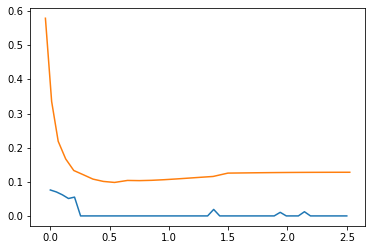

In [15]:
print(np.mean(diff, axis=1))
plt.plot(grid, np.mean(diff, axis=1))
plt.plot(Lambda, Tho_square)

#### Question 8  
Compare the previous iterative scheme $\tau_t = F_{\alpha, \delta} (\tau_{t-1})$ this with another idea to compute $\tau^*(\alpha)$, which consists, at each step t, of replacing the expectation in the right hand side of the system by averages over 100 000 independent copies of $(\Theta,Z)$. (Use 100 000 fresh independent copies at each iteration $t$). Do the two implementations coincide ? You may change the value 100 000 to a smaller/larger one depending on the power of your laptop.

In [43]:
def eta_prime(u,t):
    return int(np.abs(u) - t > 0)

def list_theta_Z(p=0.128,sigma2=0.2,test_size = 100000):
    theta = np.random.binomial(0,p,size=test_size) * np.random.choice(np.array([-1, 1]),test_size)
    Z = np.random.normal(0,sqrt(sigma2),size=test_size)
    return theta, Z

def compute_esp(tau, alpha, p=0.128, sigma2=0.2, test_size = 100000):
    theta, Z = list_theta_Z(p,sigma2,test_size)
    ETA = np.array([eta((theta + tau*Z)[i], tau*alpha) for i in range(test_size)])
    esp1 = np.mean((ETA-theta)**2)
    #tau_star = sigma2 + esp1 / delta
    ETA_PRIME = np.array([eta_prime((theta + tau*Z)[i], tau*alpha) for i in range(test_size)])
    esp2 = np.mean(ETA_PRIME)
    #b_star = tau_star * (1 - esp2 / delta)
    return esp1, esp2

print(compute_esp(sqrt(0.2 + 1/(2*0.64)),1))

(0.0011639844998460797, 0.02665)


In [44]:
def F_new(alpha, delta, tho, sigma2):
    return sigma2 + compute_esp(tho, alpha, sigma2 = sigma2)[0] / delta

def compute_b_new(tho, delta, alpha):
    return tho*(1 - compute_esp(tho,alpha,sigma2=sigma2)[1] / delta)

def solve_implement_new(F, alpha, delta, nb, tho_0, sigma2, eps):
    tho_1 = tho_0
    tho_2 = sqrt(F(alpha, delta, tho_0, sigma2))
    it = 0
    while abs(tho_1 - tho_2) > eps and it < 1000:
        print("tau_1 = ", tho_1)
        tho_1 = tho_2
        tho_2 = sqrt(F(alpha, delta, tho_1, sigma2))
        it += 1
    return tho_1

tho_0 = sqrt(0.2 + 1/(2*0.64))
tau_new = solve_implement_new(F_new, 1, 0.64, 100, tho_0, 0.2, 1e-1)
print("tau_new =", tau_new)
print("b_new = ", compute_b_new(tau,0.64,1))


tau_1 =  0.9905806378079475
tau_new = 0.44915194247124196
b_new =  0.7096416005816262
